## Implement Diffusion models code for approximating data distribution

In [1]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

/home/taeyoung/miniconda3/envs/gtg/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# seed reproduction
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
# Define base distribution
mu1 = -1.0
sigma1 = 1.0
mu2 = 4.0
sigma2 = 1.0
mix_ratio = 0.4

x_min = -7.5
x_max = 7.5

def p0(x):
    return torch.exp(-0.5 * x ** 2) / np.sqrt(2 * np.pi)

def p1(x):
    return mix_ratio * torch.exp(-0.5 * ((x - mu1) / sigma1) ** 2) / (sigma1 * np.sqrt(2 * np.pi)) + \
           (1 - mix_ratio) * torch.exp(-0.5 * ((x - mu2) / sigma2) ** 2) / (sigma2 * np.sqrt(2 * np.pi))

In [4]:
class ToyDataset(torch.utils.data.Dataset):
    def __init__(self, num_samples):
        self.data = torch.cat([
            torch.normal(mu1, sigma1, (int(num_samples * mix_ratio), 1)),
            torch.normal(mu2, sigma2, (int(num_samples * (1 - mix_ratio)), 1))
        ], dim=0)
        
        self.data_mean = self.data.mean(dim=0).unsqueeze(0)
        self.data_std = self.data.std(dim=0).unsqueeze(0)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

(-7.5, 7.5, 0.0, 0.2513339973986149)

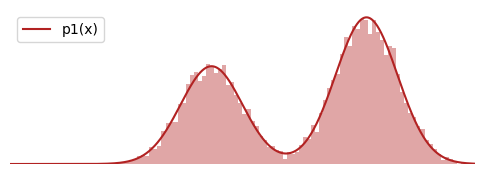

In [5]:
x_linspace = torch.linspace(x_min, x_max, 1000)

num_samples = 10000
dataset = ToyDataset(num_samples)

plt.figure(figsize=(6, 2))
plt.plot(x_linspace, p1(x_linspace), label='p1(x)', color="firebrick")
plt.hist(dataset.data.numpy(), bins=100, density=True, alpha=0.4, color='firebrick')
plt.xlim(x_min, x_max)
plt.legend()
plt.axis('off')

In [26]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    
class DiffusionModel(nn.Module):
    def __init__(self, network, diffusion_steps, schedule="linear"):
        super(DiffusionModel, self).__init__()
        self.network = network
        self.diffusion_steps = diffusion_steps
        self.schedule = schedule
        if self.schedule == "linear":
            beta1 = 0.02
            beta2 = 1e-4
            beta_t = (beta1 - beta2) * torch.arange(diffusion_steps + 1, 0, step=-1) / (
                diffusion_steps
            ) + beta2
        alpha_t = 1 - torch.flip(beta_t, dims=[0])
        log_alpha_t = torch.log(alpha_t)
        alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()
        sqrtab = torch.sqrt(alphabar_t)
        oneover_sqrta = 1 / torch.sqrt(alpha_t)
        sqrtmab = torch.sqrt(1 - alphabar_t)
        mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab
        self.register_buffer("beta_t", beta_t)
        self.register_buffer("alpha_t", torch.flip(alpha_t, dims=[0]))
        self.register_buffer("log_alpha_t", torch.flip(log_alpha_t, dims=[0]))
        self.register_buffer("alphabar_t", torch.flip(alphabar_t, dims=[0]))
        self.register_buffer("sqrtab", torch.flip(sqrtab, dims=[0]))
        self.register_buffer("oneover_sqrta", torch.flip(oneover_sqrta, dims=[0]))
        self.register_buffer("sqrtmab", torch.flip(sqrtmab, dims=[0]))
        self.register_buffer("mab_over_sqrtmab_inv", torch.flip(mab_over_sqrtmab_inv, dims=[0]))
        
    
class Trainer:
    def __init__(self, dataset, model, optimizer, batch_size, num_epochs, device):
        self.dataset = dataset
        self.model = model
        self.optimizer = optimizer
        
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        
        self.device = device
        
    def train(self):
        self.model.train()
        data_loader = torch.utils.data.DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True)
        
        for epoch in range(self.num_epochs):
            for batch in data_loader:
                batch = (batch - self.dataset.data_mean) / self.dataset.data_std
                batch = batch.to(self.device)
                self.optimizer.zero_grad()
                loss = self.compute_loss(batch)
                loss.backward()
                self.optimizer.step()
                
            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item():.4f}')
                
    def compute_loss(self, batch):
        t_idx = torch.randint(0, self.model.diffusion_steps, (batch.shape[0], 1), device=self.device)
        t = t_idx.float() / self.model.diffusion_steps
        
        epsilon = torch.randn_like(batch).to(self.device)
        x_t = self.model.sqrtab[t_idx] * batch + self.model.sqrtmab[t_idx] * epsilon
        epsilon_pred = self.model.network(torch.cat((x_t, t), dim=-1))
        loss = F.mse_loss(epsilon_pred, epsilon)
        return loss
    
    def sample(self, sample_size, dim):
        x0 = torch.randn(sample_size, dim).to(self.device)
        trajectory = []
        xt = x0.clone()
        for timestep in range(self.model.diffusion_steps):
            t_idx = torch.full((sample_size, 1), timestep, device=self.device)
            t = t_idx.float() / self.model.diffusion_steps
            epsilon_pred = self.model.network(torch.cat((xt, t), dim=-1))
            xt = self.model.oneover_sqrta[t_idx] * (xt - self.model.mab_over_sqrtmab_inv[t_idx] * epsilon_pred) + torch.sqrt(self.model.beta_t[t_idx]) * torch.randn_like(xt).to(self.device)   
            trajectory.append((xt.cpu() * (1 + (self.dataset.data_std - 1) * t.cpu()) + self.dataset.data_mean * t.cpu()).detach().numpy())
        trajectory = np.stack(trajectory, axis=0)
        return trajectory

In [27]:
dim = 1
batch_size = 256
num_epochs = 100
hidden_dim = 128
learning_rate = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
network = MLP(input_dim=dim + 1, hidden_dim=hidden_dim, output_dim=dim).to(device)
diffusion_steps = 100
model = DiffusionModel(network, diffusion_steps).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
trainer = Trainer(dataset, model, optimizer, batch_size, num_epochs, device)

trainer.train()

Epoch 0, Loss: 1.1031
Epoch 10, Loss: 0.4250
Epoch 20, Loss: 0.5929
Epoch 30, Loss: 0.2148
Epoch 40, Loss: 0.4124
Epoch 50, Loss: 0.8444
Epoch 60, Loss: 1.1849
Epoch 70, Loss: 0.9871
Epoch 80, Loss: 0.7038
Epoch 90, Loss: 0.5144


In [29]:
trajectory = trainer.sample(num_samples, dim)

(-7.5, 7.5, 0.4356163734595783, 0.0)

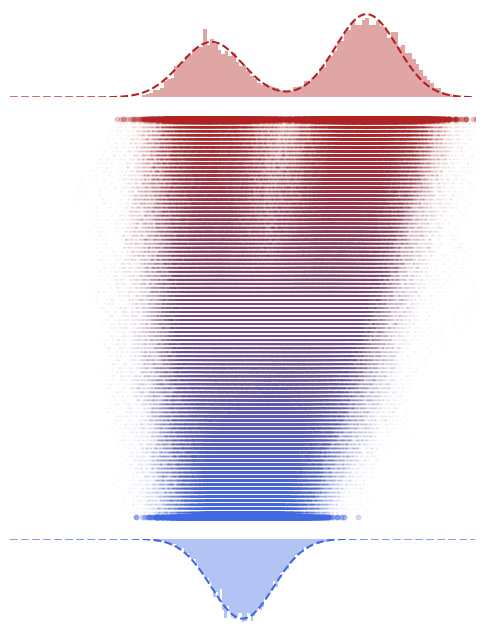

In [30]:
fig = plt.figure(figsize=(6, 8))
gs = fig.add_gridspec(3, 1, height_ratios=[0.2, 1.0, 0.2], hspace=0.01)

ax0 = fig.add_subplot(gs[0, 0])
plt.hist(trajectory[-1, :, 0], bins=100, density=True, alpha=0.4, color='firebrick')
ax0.plot(x_linspace, p1(x_linspace), label='p1(x)', linestyle="--", color="firebrick")
ax0.set_xlim(x_min, x_max)
ax0.axis("off")

# Add main scatter plot
ax1 = fig.add_subplot(gs[1, 0])
ax1.scatter(trajectory[-1, :, 0], np.ones_like(trajectory[-1, :, 0]), s=10, alpha=0.2, c="firebrick")
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["royalblue", "firebrick"])
ax1.scatter(trajectory[:, :, 0], np.linspace(0, 1, diffusion_steps)[:, None] * np.ones_like(trajectory[:, :, 0]), s=0.2, alpha=0.05, c=np.linspace(0, 1, diffusion_steps)[:, None] * np.ones_like(trajectory[:, :, 0]), cmap=cmap)
ax1.scatter(trajectory[0, :, 0], np.zeros_like(trajectory[0, :, 0]), s=10, alpha=0.2, c="royalblue")
ax1.set_xlim(x_min, x_max)
ax1.axis("off")

ax2 = fig.add_subplot(gs[2, 0])
plt.hist(trajectory[0, :, 0], bins=100, density=True, alpha=0.4, color='royalblue')
ax2.plot(x_linspace, p0(x_linspace), label='p0(x)', linestyle="--", color="royalblue")
ax2.set_xlim(x_min, x_max)
ax2.invert_yaxis()
ax2.axis("off")